Kotug Project, Group 1

Allan Guzman, June Chen, Sarah Blanc

Let's maybe first remember here the research questions of this project:

**Main Research Question**:

"How can the reliability and efficiency of Kotug OptiPort's tugboat scheduling tool be enhanced through the development and evaluation of novel methods for predicting pickup and drop-off coordinates and other relevant variables?"

**Subresearch Questions**:

- "What advanced predictive methods can be developed and implemented to accurately forecast the coordinates (latitude and longitude) for pickup and drop-off locations of tugs on vessels in the port of Rotterdam?"
- "Which variables, including AIS data, customer requirements, and port-specific constraints (or lack thereof), play a significant role in determining the pickup and drop-off locations and timing of tugs, as well as the required number of tugs for each vessel operation in the port of Rotterdam, and why are they important?"
- "Which of the above mentioned variables can be combined in order to increase the reliability of the results, and why can they be combined?"

The work on this first research question in done in this file, while the 2 other subquestions are answered in the file called "Data_preparation". Finally, this file also contains the conclusion of this project (see end of the file).


**Predictions**

In this notebook, the primary objective is to predict the pick-up and drop-off locations of vessels. Given the variation in data availability across different harbors, a strategic approach was adopted. We specifically target a single harbor for analysis. The flexibility of our model allows us to select any harbor for analysis simply by modifying a designated variable in the code.

To elaborate, we begin by choosing a harbor with substantial data volume. All relevant data pertaining to incoming and departing vessels from this selected harbor is extracted. Our model is then applied to this subset of data. Notably, the ability to change the harbor variable in the code grants the flexibility to extend this analysis to other harbors seamlessly.

Additionally, it is crucial to handle incoming and departing vessels separately in our analysis. Within the chosen harbor's dataset, we further categorize the data. Leaving vessels form one subset, while incoming vessels constitute another. This approach is grounded in the inherent knowledge possessed by vessels and drivers. Specifically, vessels are inherently aware of their status as incoming or departing, and they are assigned to specific ports. These foundational assumptions underpin our analytical framework, ensuring a focused and accurate prediction methodology.

Literature review that explains the path followed through the different methods used:

As part of our effort to answer the first research question and to identify appropriate techniques for geospatial data processing, we painstakingly carried out a literature research. There were two goals in mind: finding viable approaches and understanding how they may be used in the field. Our investigation produced important findings that shaped our methodology. The key findings were the following:
1. Integrated prediction over isolated coordinates: We could have been tempted at first to use several regression models to predict latitude and longitude independently. The literature, however, strongly advises against this practise. Researchers and academics often advise against this segmentation. This advice is supported by the fact that latitude and longitude have complex interactions that are difficult to fully comprehend when viewed as separate concepts. As a result, we began to concentrate on holistic approaches that take into account all of these factors at once.
2. The potential of decision tree classifiers on our discretized polygon of water: Among the methods for classifying our data that showed promise was the decision tree classifier, especially when it came to pick-up and drop-off location prediction. It is not without restrictions, despite its potential. Indeed, we could use it, however we should create a dependence between squares (notable squares that are close to each other as an example). This could be done via new variables that we do not have. Developping them would be too complicated to apply in this project. Furthermore, its failure to adequately incorporate the geospatial nuances of our scenario is a major limitation. This insight drove us to read more in the literature and look for techniques that include the geographical dimension from the beginning. However, you can still see the results from this first method below.  
3.  Introducing kriging, a spatial regression method: Our research introduced us to the Kriging technique, which is a very relevant method for our needs regarding the classification of geospatial data. This could be done on our discretized polygon of water. Furthermore, it is a reliable framework for position prediction that takes into consideration the underlying spatial patterns. Using the spatial correlations found in our data, this approach solves our categorization problem in a way that is contextually rich and nuanced. Unfortunately, after reading a lot about it, we again remarked that this method asks for a lot of complicated work before applying the method. We do not have the knowledges now to handle it in a way that allows us to produce convincing results. Thus, we decided to search for further possible methods.
4. We reached the consensus that it's essential to reconsider approaches that don't rely on our discretized polygon. This broader perspective ensures we're not confined by our initial decision to go for this polygon. Following a brainstorming session and further reading of papers, we determined that ...... TO BE COMPLETED


## Import the required librairies

In [23]:
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import matplotlib.pyplot as plt
import re
import seaborn as sn

import folium
import rasterio
import rasterio.mask

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from geopy.distance import geodesic
import folium

from shapely.geometry import Point, Polygon, LineString
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from pyproj import Geod

## Import raw data

In [24]:
incoming_weather_size_draught = gpd.read_file('Data/Input_ML/incoming_weather_size_draught.geojson')
incoming_weather_size = gpd.read_file('Data/Input_ML/incoming_weather_size.geojson')
incoming_weather = gpd.read_file('Data/Input_ML/incoming_weather.geojson')

In [41]:
havens = list(incoming_weather_size_draught['to_haven'].unique())

In [25]:
incoming_weather_size.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5466 entries, 0 to 5465
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   area_ID              5466 non-null   int64              
 1   center               5466 non-null   object             
 2   from                 5466 non-null   object             
 3   from_rounded         5466 non-null   datetime64[ns, UTC]
 4   to_haven             5466 non-null   object             
 5   trip_ID              5466 non-null   int64              
 6   vessel_mmsi          5466 non-null   int64              
 7   area                 5466 non-null   object             
 8   Wind_Direction_Cat1  5466 non-null   object             
 9   Wind_Direction_Cat2  5466 non-null   object             
 10  Wind_Speed           5466 non-null   int64              
 11  d_from_haven         5466 non-null   float64            
 12  d_to_haven  

In [26]:
leaving_weather_size_draught = gpd.read_file('Data/Input_ML/leaving_weather_size_draught.geojson')
leaving_weather_size = gpd.read_file('Data/Input_ML/leaving_weather_size.geojson')
leaving_weather = gpd.read_file('Data/Input_ML/leaving_weather.geojson')

In [27]:
leaving_weather_size_draught.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2302 entries, 0 to 2301
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   area_ID              2302 non-null   int64              
 1   center               2302 non-null   object             
 2   to                   2302 non-null   object             
 3   to_rounded           2302 non-null   datetime64[ns, UTC]
 4   from_haven           2302 non-null   object             
 5   trip_ID              2302 non-null   int64              
 6   vessel_mmsi          2302 non-null   int64              
 7   area                 2302 non-null   object             
 8   Wind_Direction_Cat1  2302 non-null   object             
 9   Wind_Direction_Cat2  2302 non-null   object             
 10  Wind_Speed           2302 non-null   int64              
 11  d_from_haven         2302 non-null   float64            
 12  d_to_haven  

Extraction of the data that concerns the most used harbours (one for leaving vessels and one for incoming vessels)

In [28]:
columns_leaving_trajectories = [
    'from_haven',
    'Wind_Direction',
    'Wind_Speed',
    'Lenght',
    'Width',
    'Type_Cat',
    'd_from_haven'
]

columns_incoming_trajectories = [
    'to_haven',
    'Wind_Direction',
    'Wind_Speed',
    'Lenght'	,
    'Width'	,
    'Type_Cat',
    'd_to_haven'
]

Check of potential correlations in the data

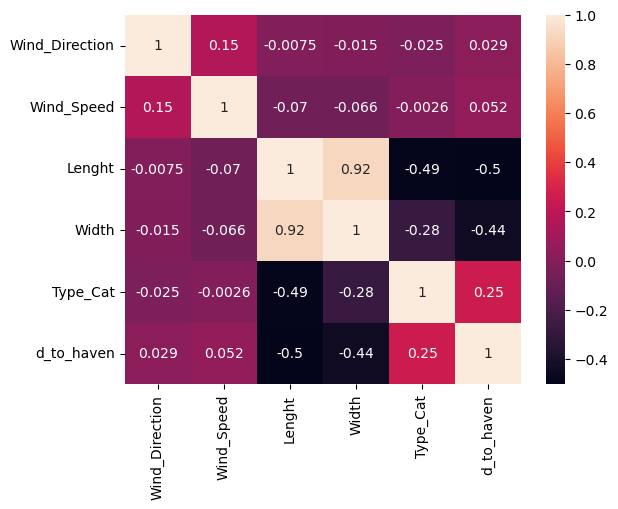

In [29]:
corr_matrix_incoming = incoming_weather_size_draught[columns_incoming_trajectories]
corr_matrix_incoming = corr_matrix_incoming.drop(columns = 'to_haven').corr()
sn.heatmap(corr_matrix_incoming, annot=True)
plt.show()

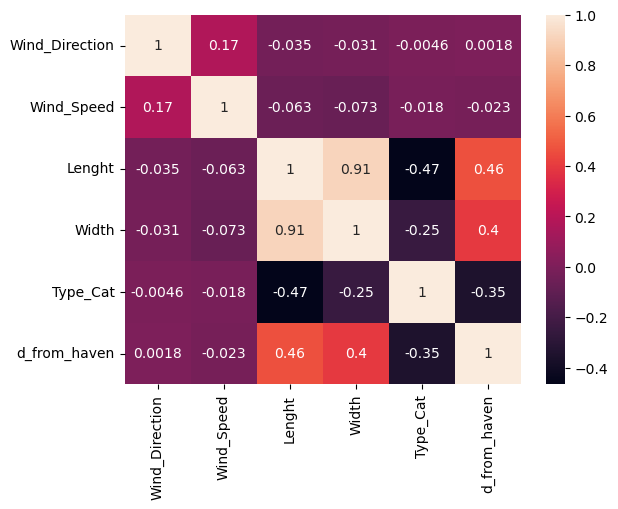

In [30]:
corr_matrix_leaving = leaving_weather_size_draught[columns_leaving_trajectories]
corr_matrix_leaving = corr_matrix_leaving.drop(columns = 'from_haven').corr()
sn.heatmap(corr_matrix_leaving, annot=True)
plt.show()

As observed, aside from Length and Width, there are no notably high correlations within the datasets.

**BELOW, YOU CAN SEE THE IMPLEMENTATION OF THE POINT 2 FROM THE LITERATURE REVIEW: THE DECISION TREE ON THE DISCRETIZED POLYGON.**

# Trajectories approach

In [31]:
incoming_trajectories = incoming_weather_size_draught[columns_incoming_trajectories]
incoming_trajectories = incoming_trajectories.groupby('to_haven').apply(lambda x: x).drop(columns = 'to_haven')


In [32]:
incoming_trajectories

Wind_Direction  Wind_Speed  Lenght  Width  Type_Cat  \
to_haven                                                             
3PET     0                  6          30   159.0   27.0         2   
         1                  7         100   159.0   27.0         2   
         23                 2          90   184.0   27.0         2   
         24                 1          80   184.0   27.0         2   
         29                 6          40   170.0   26.0         2   
...                       ...         ...     ...    ...       ...   
YANG     2473               0          40   290.0   46.0         2   
         2483               7          30   364.0   46.0         0   
         2485               8          60   274.0   48.0         2   
         2488               2         120   274.0   48.0         2   
         2497               5          70   275.0   48.0         2   

                d_to_haven  
to_haven                    
3PET     0        0.000000  
         1      630.919140  
         23    1799.984038  
         24    1306.298799  
         29    2352.600292  
...                    ...  
YANG     2473  1218.667765  
         2483  1842.479636  
         2485     0.000000  
         2488  1038.457248  
         2497  8680.060123  

[2547 rows x 6 columns]

In [74]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def Random_forest(grouped_df, haven):
    haven_df = grouped_df.loc[haven]

    X = haven_df.drop(columns= 'd_to_haven')
    y = haven_df['d_to_haven'] 

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and train the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)

    # Add the predicted distances to the original DataFrame
    X_test['predicted_distance'] = y_pred

    X_test['original_distance'] = haven_df['d_to_haven'].loc[list(X_test.index.values)]
    X_test['diff_dist'] = abs(X_test['predicted_distance']  - X_test['original_distance'])
    
    average_diff = X_test['diff_dist'].mean()

    values = [average_diff]
    columns = ['avg_diff']

    # You can also access feature importances
    feature_importances = rf_model.feature_importances_.tolist()

    values.extend(feature_importances)
    columns.extend(X.columns)

    values.extend([haven])
    columns.extend(['haven'])

    output = pd.DataFrame([values], columns=columns)

    return output, X_test

# # Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"Mean Squared Error: {mse:.2f}")
# print(f"R-squared (R2): {r2:.2f}")



# Now, your DataFrame 'df' contains a new column 'predicted_distance' with the predictions.


In [78]:
output = []
overall_avg = []
for haven in havens:
    avg_diff, pred = Random_forest(incoming_trajectories, haven)
    overall_avg.extend(list(pred['diff_dist']))
    output.append(avg_diff)

print(sum(overall_avg)/len(overall_avg))
pd.concat(output).reset_index(drop= True)

1050.6315016069377


,avg_diff,Wind_Direction,Wind_Speed,Lenght,Width,Type_Cat,haven
0,861.254675,0.224437,0.259506,0.323764,0.192293,0.000000,3PET
1,690.717969,0.286619,0.303499,0.267335,0.129228,0.013319,PET8
2,603.989579,0.107526,0.158392,0.535464,0.198618,0.000000,AMAZ
3,882.088754,0.143865,0.185903,0.475506,0.173219,0.021507,EURO
4,1374.674628,0.098096,0.166267,0.639018,0.095338,0.001282,AMALIA
5,1004.614557,0.075155,0.107247,0.503531,0.213919,0.100148,YANG
6,1426.486202,0.188461,0.240462,0.367820,0.183527,0.019730,CKVTTI
7,1363.921374,0.168008,0.203784,0.405744,0.221625,0.000839,7PET
8,766.504703,0.210797,0.260287,0.237094,0.259586,0.032236,MISS
9,1065.396091,0.204749,0.164258,0.334126,0.262006,0.034861,WAAL


In [116]:
def trajectory_classification(grouped_df, haven):
    haven_data = grouped_df.loc[haven]
    X = haven_data.drop(columns= 'd_to_haven')
    y = haven_data['d_to_haven']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
    


to_haven      
3PET      0          0.000000
          1        629.430921
          23      1795.935183
          24      1303.474140
          29      2347.385090
                     ...     
YANG      2473    1154.566618
          2483    1778.543152
          2485       0.000000
          2488     974.118683
          2497    8628.836551
Name: d_to_haven, Length: 2547, dtype: float64

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# Areas approach

**Prediction for LEAVING**

Code to know what are the 2 most used harbour for the incoming and leaving vessels

In [ ]:
leaving_top = leaving_weather_size_draught['from_haven'].value_counts()
incoming_top = incoming_weather_size_draught['to_haven'].value_counts()
print(leaving_top[0:2])
print(incoming_top[0:2])

from_haven
EURO      451
AMALIA    309
Name: count, dtype: int64
to_haven
EURO    480
7PET    377
Name: count, dtype: int64


In [ ]:
incoming_harbor = 'EURO'
leaving_harbor = 'EURO'

leaving_weather_size_draught_top = leaving_weather_size_draught[leaving_weather_size_draught['from_haven']==leaving_harbor]
incoming_weather_size_draught_top = incoming_weather_size_draught[incoming_weather_size_draught['to_haven']==incoming_harbor]


In [ ]:
columns_leaving_areas = [
    #'from_haven',
    'Wind_Direction',
    'Wind_Speed',
    'Lenght',
    'Width',
    'Type',
]

columns_incoming_areas = [
    #'to_haven',
    'Wind_Direction',
    'Wind_Speed',
    'Lenght'	,
    'Width'	,
    'Type',
]

In [97]:
X = leaving_weather_size_draught_top[columns_leaving_areas]
y = leaving_weather_size_draught_top['area_ID']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=3)
#X_from_lat_train, X_from_lat_test, y_from_lat_train, y_from_lat_test = train_test_split(leaving_weather_size_draught[columns_leaving], leaving_weather_size_draught['area_ID'], test_size=0.3, random_state=42)
data = X_test

In [98]:
print("Number of features in training data:", X_train.shape[1]) 
print("Number of features in test data:", X_test.shape[1])

Number of features in training data: 5
Number of features in test data: 5


Decision Tree Classifier

In [99]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.datasets import load_iris


# Initialize the Decision Tree Classifier
decision_tree_classifier = DecisionTreeClassifier(random_state=3)

# Train the classifier using the training data
x = decision_tree_classifier.fit(X_train, y_train)

# Make predictions on the test data
predictions = decision_tree_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)

print("Accuracy of the Decision Tree Classifier: {:.2f}%".format(accuracy * 100))

# Add predictions to the original DataFrame

data['Predicted_Area_ID'] = predictions




Accuracy of the Decision Tree Classifier: 19.03%


In [100]:
merged_df = pd.merge(data, leaving_weather_size_draught, left_index=True, right_index=True, how='left')
#merged_df

In [101]:
# Create a new empty list to store prediction_center values
prediction_centers = []

# Iterate through the rows of merged_df
for index, row in merged_df.iterrows():
    # Get the Predicted_Area_ID value from the current row of merged_df
    predicted_area_id = row['Predicted_Area_ID']
    
    # Find the corresponding row in incoming_weather_size_draught where area_ID matches Predicted_Area_ID
    matching_row = leaving_weather_size_draught[leaving_weather_size_draught['area_ID'] == predicted_area_id]
    
    # Check if a matching row is found
    if not matching_row.empty:
        # Get the value from the 'center' column in the matching row
        prediction_center = matching_row['center'].values[0]
    else:
        # If no matching row is found, assign a default value (you can change this as per your requirement)
        prediction_center = None
    
    # Append the prediction_center value to the list
    prediction_centers.append(prediction_center)

# Add the prediction_centers list as a new column to merged_df
merged_df['prediction_center'] = prediction_centers

#merged_df

In [103]:
merged_df

,Wind_Direction_x,Wind_Speed_x,Lenght_x,Width_x,Type_x,Predicted_Area_ID,area_ID,center,to,to_rounded,...,Wind_Speed_y,d_from_haven,d_to_haven,Lenght_y,Width_y,Type_y,Navigation_draught,geometry,Wind_Direction_y,prediction_center
849,1,6,399.0,54.0,0,1225,1224,POINT (4.087284503833875 51.966239519473156),2022-07-14T22:26:04+00:00,2022-07-14 22:00:00+00:00,...,6,3387.739178,2995.231210,399.0,54.0,0,10.0,POINT (4.08806 51.96917),1,POINT (4.087284503833875 51.972598683533285)
375,2,5,275.0,40.0,0,1224,1225,POINT (4.087284503833875 51.972598683533285),2022-07-02T07:40:01+00:00,2022-07-02 08:00:00+00:00,...,5,3576.123183,2806.847206,275.0,40.0,0,11.7,POINT (4.08813 51.97141),2,POINT (4.087284503833875 51.966239519473156)
954,1,5,306.0,40.0,0,1183,1186,POINT (4.0808868772623645 51.97886976519478),2022-07-07T22:37:41+00:00,2022-07-07 23:00:00+00:00,...,5,4275.508552,2107.461837,306.0,40.0,0,13.3,POINT (4.08239 51.97785),1,POINT (4.0809253397737475 51.95988035541303)
691,1,1,220.0,33.0,0,1225,1063,POINT (4.061780049795423 51.96113970048921),2022-07-18T11:17:17+00:00,2022-07-18 11:00:00+00:00,...,1,841.050069,5541.920319,220.0,33.0,0,8.2,POINT (4.06466 51.96093),1,POINT (4.087284503833875 51.972598683533285)
1948,2,4,336.0,45.0,0,1067,1225,POINT (4.087284503833875 51.972598683533285),2022-10-21T00:29:28+00:00,2022-10-21 00:00:00+00:00,...,4,3693.376653,2689.593735,336.0,45.0,0,12.6,POINT (4.08997 51.97331),2,POINT (4.061847847593366 51.98531701165355)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,2,6,220.0,33.0,0,1185,1183,POINT (4.0809253397737475 51.95988035541303),2022-12-22T12:28:17+00:00,2022-12-22 12:00:00+00:00,...,6,2046.496530,4336.473858,220.0,33.0,0,9.2,POINT (4.07947 51.96167),2,POINT (4.080970466897103 51.972806813886265)
1619,0,6,328.5,46.0,0,1183,1225,POINT (4.087284503833875 51.972598683533285),2022-09-02T14:12:05+00:00,2022-09-02 14:00:00+00:00,...,6,3723.758056,2659.212332,328.5,46.0,0,11.4,POINT (4.08710 51.97277),0,POINT (4.0809253397737475 51.95988035541303)
184,3,4,294.0,32.0,0,1224,988,POINT (4.0491335556626495 51.99162927499277),2022-07-05T09:19:56+00:00,2022-07-05 09:00:00+00:00,...,4,6382.970388,0.000000,294.0,32.0,0,12.3,POINT (4.04934 51.99057),3,POINT (4.087284503833875 51.966239519473156)
1476,2,4,194.0,28.0,0,1063,1224,POINT (4.087284503833875 51.966239519473156),2022-08-16T10:02:51+00:00,2022-08-16 10:00:00+00:00,...,4,3180.699821,3202.270568,194.0,28.0,0,9.8,POINT (4.08631 51.96709),2,POINT (4.061780049795423 51.96113970048921)


In [102]:
# Function to convert string representation of coordinates to actual coordinates
def parse_coordinates(coord_str):
    if coord_str:
        # Extract numerical values from the string (format: 'POINT (longitude latitude)')
        coordinates = re.findall(r"[-+]?\d*\.\d+|\d+", coord_str)
        lat, lon = map(float, coordinates)
        return lat, lon
    else:
        return None

# Convert 'from_location' and 'center' columns to actual coordinates
merged_df['to_location_coords'] = merged_df['to_location'].apply(parse_coordinates)
merged_df['center_coords'] = merged_df['prediction_center'].apply(parse_coordinates)

# Function to calculate distance between two points using geodesic
def calculate_distance(row):
    if row['to_location_coords'] and row['center_coords']:
        return geodesic(row['to_location_coords'], row['center_coords']).meters
    else:
        return None

# Apply the calculate_distance function to the DataFrame to compute distances
merged_df['distance_to_predicted_center'] = merged_df.apply(calculate_distance, axis=1)
moyenne_distance = merged_df['distance_to_predicted_center'].mean()

# Afficher la moyenne
print("Average distance between predicted and real locations: ", moyenne_distance, "meters")



KeyError: 'to_location'

**Predictions for INCOMING**

In [18]:
X = incoming_weather_size_draught_top[columns_incoming_areas]
y = incoming_weather_size_draught_top['area_ID']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=3)
#X_from_lat_train, X_from_lat_test, y_from_lat_train, y_from_lat_test = train_test_split(leaving_weather_size_draught[columns_leaving], leaving_weather_size_draught['area_ID'], test_size=0.3, random_state=42)
data = X_test

In [19]:
print("Number of features in training data:", X_train.shape[1])
print("Number of features in test data:", X_test.shape[1])

Number of features in training data: 5
Number of features in test data: 5


In [20]:

# Initialize the Decision Tree Classifier
decision_tree_classifier = DecisionTreeClassifier(random_state=3)

# Train the classifier using the training data
x = decision_tree_classifier.fit(X_train, y_train)

# Make predictions on the test data
predictions = decision_tree_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)

print("Accuracy of the Decision Tree Classifier: {:.2f}%".format(accuracy * 100))

# Add predictions to the original DataFrame

data['Predicted_Area_ID'] = predictions


Accuracy of the Decision Tree Classifier: 12.92%


,Direction,Wind_speed,Lenght,Width,Type,Predicted_Area_ID
219,2,1,299.0,49.0,0,1224
772,5,3,300.0,40.0,0,1027
600,8,0,243.0,32.0,0,1103
2258,7,1,366.0,48.0,0,1067
2033,5,0,333.0,48.0,0,1107
...,...,...,...,...,...,...
407,7,1,270.0,40.0,0,1106
1780,5,3,300.0,40.0,0,1027
1224,5,3,300.0,43.0,0,1106
3032,6,1,300.0,48.0,0,1186


In [21]:
merged_df = pd.merge(data, incoming_weather_size_draught, left_index=True, right_index=True, how='left')
#merged_df

In [22]:
# Create a new empty list to store prediction_center values
prediction_centers = []

# Iterate through the rows of merged_df
for index, row in merged_df.iterrows():
    # Get the Predicted_Area_ID value from the current row of merged_df
    predicted_area_id = row['Predicted_Area_ID']
    
    # Find the corresponding row in incoming_weather_size_draught where area_ID matches Predicted_Area_ID
    matching_row = incoming_weather_size_draught[incoming_weather_size_draught['area_ID'] == predicted_area_id]
    
    # Check if a matching row is found
    if not matching_row.empty:
        # Get the value from the 'center' column in the matching row
        prediction_center = matching_row['center'].values[0]
    else:
        # If no matching row is found, assign a default value (you can change this as per your requirement)
        prediction_center = None
    
    # Append the prediction_center value to the list
    prediction_centers.append(prediction_center)

# Add the prediction_centers list as a new column to merged_df
merged_df['prediction_center'] = prediction_centers

#merged_df

In [24]:
# Function to convert string representation of coordinates to actual coordinates
def parse_coordinates(coord_str):
    if coord_str:
        # Extract numerical values from the string (format: 'POINT (longitude latitude)')
        coordinates = re.findall(r"[-+]?\d*\.\d+|\d+", coord_str)
        lat, lon = map(float, coordinates)
        return lat, lon
    else:
        return None

# Convert 'to_location' and 'center' columns to actual coordinates
merged_df['from_location_coords'] = merged_df['from_location'].apply(parse_coordinates)
merged_df['center_coords'] = merged_df['prediction_center'].apply(parse_coordinates)

# Function to calculate distance between two points using geodesic
def calculate_distance(row):
    if row['from_location_coords'] and row['center_coords']:
        return geodesic(row['from_location_coords'], row['center_coords']).meters
    else:
        return None

# Apply the calculate_distance function to the DataFrame to compute distances
merged_df['distance_to_predicted_center'] = merged_df.apply(calculate_distance, axis=1)
moyenne_distance = merged_df['distance_to_predicted_center'].mean()

# Afficher la moyenne
print("Average distance between predicted and real locations: ", moyenne_distance, "meters")


Average distance between predicted and real locations:  1418.1801243934678 meters


**BELOW, YOU CAN SEE THE IMPLEMENTATION OF THE POINT 4 FROM THE LITERATURE REVIEW: ... TO BE COMPLETED.**

**CONCLUSION**

...